In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder,FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.metrics import r2_score

In [ ]:
df = pd.read_csv('/content/car_sales_data.csv',nrows=1000,usecols=['Manufacturer','Engine size','Fuel type','Mileage','Price'])
df.head()

,Manufacturer,Engine size,Fuel type,Mileage,Price
0,Ford,1.0,Petrol,127300,3074
1,Porsche,4.0,Petrol,57850,49704
2,Ford,1.6,Diesel,39190,24072
3,Toyota,1.8,Hybrid,210814,1705
4,VW,1.0,Petrol,127869,4101


# Without Pipelines and Transformer

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(df.iloc[:,:4],df.iloc[:,-1],test_size=0.2,random_state=34)

In [ ]:
X_train

,Manufacturer,Engine size,Fuel type,Mileage
634,Ford,1.6,Diesel,85455
512,Ford,1.8,Diesel,50432
144,Toyota,1.0,Hybrid,46972
503,VW,1.4,Petrol,45610
722,VW,1.4,Petrol,24430
...,...,...,...,...
758,Toyota,1.0,Petrol,58886
873,VW,1.6,Petrol,311658
490,Ford,2.0,Diesel,70202
122,Toyota,1.8,Hybrid,119097


In [ ]:
# Applying One hot Encoding
ohe = OneHotEncoder(sparse_output=False,drop='first',handle_unknown='ignore')
X_train_ohe = ohe.fit_transform(X_train[['Manufacturer','Fuel type']])
X_test_ohe = ohe.transform(X_test[['Manufacturer','Fuel type']])

In [ ]:
# Applying Function Transformer on Mileage column
X_train_mileage_transformed = np.sqrt(X_train['Mileage'])
X_test_mileage_transformed = np.sqrt(X_test['Mileage'])

Text(0.5, 1.0, 'Mileage PDF')

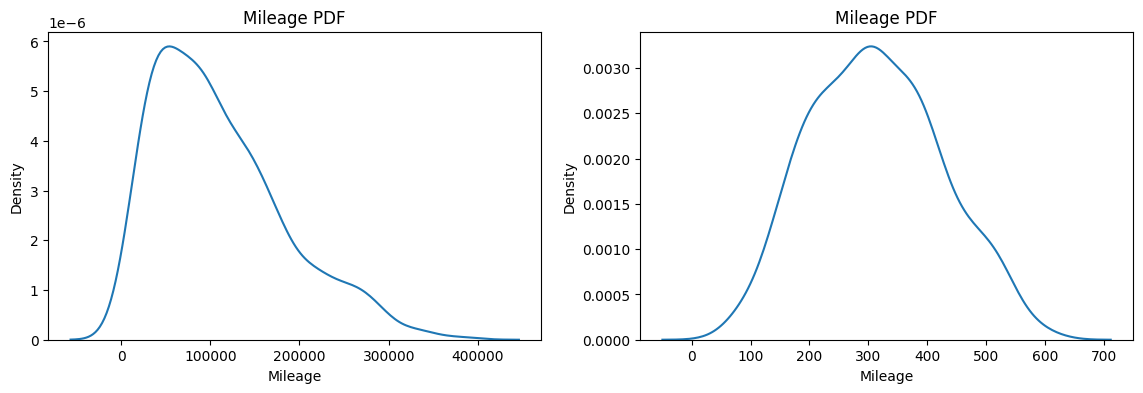

In [ ]:
plt.figure(figsize=(14,4))
plt.subplot(121)
sns.kdeplot(X_train['Mileage'])
plt.title('Mileage PDF')

plt.subplot(122)
sns.kdeplot(X_train_mileage_transformed)
plt.title('Mileage PDF')

Text(0.5, 1.0, 'Mileage QQ Plot')

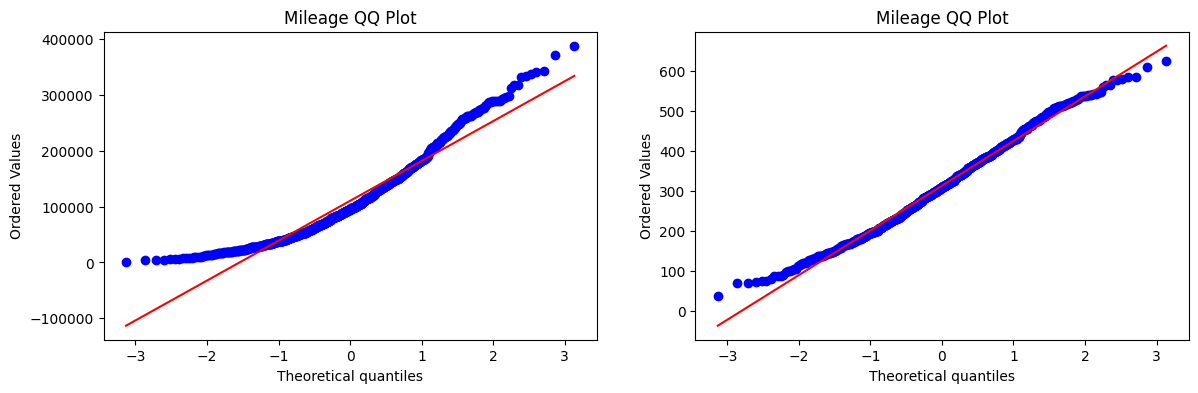

In [ ]:
plt.figure(figsize=(14,4))

plt.subplot(121)
stats.probplot(X_train['Mileage'], dist="norm", plot=plt)
plt.title('Mileage QQ Plot')

plt.subplot(122)
stats.probplot(X_train_mileage_transformed, dist="norm", plot=plt)
plt.title('Mileage QQ Plot')

In [ ]:
minmax = MinMaxScaler()
X_train_mileage_scaled = minmax.fit_transform(X_train_mileage_transformed.values.reshape(X_train_mileage_transformed.shape[0],1))
X_test_mileage_scaled = minmax.transform(X_test_mileage_transformed.values.reshape(X_test_mileage_transformed.shape[0],1))

In [ ]:
X_train_new = np.concatenate((X_train['Engine size'].values.reshape(X_train['Engine size'].shape[0],1),X_train_mileage_scaled,X_train_ohe),axis=1)
X_test_new = np.concatenate((X_test['Engine size'].values.reshape(X_test['Engine size'].shape[0],1),X_test_mileage_scaled,X_test_ohe),axis=1)

In [ ]:
lr = LinearRegression()
lr.fit(X_train_new,y_train)

LinearRegression()

In [ ]:
y_pred1 = lr.predict(X_test_new)
r2_score(y_test,y_pred1)

0.6859592782235711

# With Pipeline and ColumnTransformer

In [ ]:
# ColumnTransformer for One Hot Encoding
tnf1 = ColumnTransformer([
    ('ohe',OneHotEncoder(sparse_output=False,drop='first',handle_unknown='ignore'),[0,2])
],remainder='passthrough')

In [ ]:
# ColumnTransformer for Function Transformer
tnf2 = ColumnTransformer([
    ('func_trans', FunctionTransformer(func=np.sqrt),[3])
],remainder='passthrough')

In [ ]:
# ColumnTransformer for MinMaxScaling
tnf3 = ColumnTransformer([
    ('scaling',MinMaxScaler(),[3])
],remainder='passthrough')

In [ ]:
tnf4 = LinearRegression()

In [ ]:
pipe = Pipeline([
    ('tnf1',tnf1),
    ('tnf2',tnf2),
    ('tnf3',tnf3),
    ('tnf4',tnf4)
])

In [ ]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('tnf1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  [0, 2])])),
                ('tnf2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('func_trans',
                                                  FunctionTransformer(func=<ufunc 'sqrt'>),
                                                  [3])])),
                ('tnf3',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaling', MinMaxScaler(),
                                                  [3])])),
                ('tnf4', LinearRegression())])

In [ ]:
y_pred2 = pipe.predict(X_test)
r2_score(y_test,y_pred2)

0.5953316505584385

### The difference in r2_score may be because of concatenated differently, it does not matter much here.We Mostly use Pipelines and hyperparameter which will boost r2_score.